In [152]:
import pandas as pd 
from data_loading import load_tabular_data, preprocess_data
from NN import NN
import torch
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbn

In [228]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.) # saves to disk

In [229]:
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('standard', 'train.csv', 'valid.csv', 'test.csv')
x_train, y_train, x_valid, y_valid, x_test, y_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(x_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [230]:
model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid)
model

NN(
  (f): Sequential(
    (0): Linear(in_features=108, out_features=100, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [231]:
num_epochs = 100
burnin = 0
###
crit = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters())

cosine_similarity = torch.nn.CosineSimilarity(dim=0)

sim_vals = np.zeros((x_train.size(0), (num_epochs-burnin)))

for epoch in range(num_epochs): 

    if epoch >= burnin: 
        # step 1: compute validation gradient
        optim.zero_grad()
        yhat_valid = model(x_valid).squeeze()
        loss = crit(yhat_valid, y_valid)
        loss.backward()
        grad_valid = torch.cat([p.grad.view(-1) for p in model.parameters()])

        # step 2: for each train sample 
        for j in range(x_train.size(0)): 
            optim.zero_grad()
            x_j = x_train[[j], :]
            y_j = y_train[[j]]
            
            # a) compute sample gradient 
            yhat_j = model(x_j).squeeze(1)
            loss_j = crit(yhat_j, y_j)
            loss_j.backward()
            grad_j = torch.cat([p.grad.view(-1) for p in model.parameters()])
            
            # b compute cosine similarity with validation gradient 
            sim_vals[j, epoch-burnin] = cosine_similarity(grad_valid, grad_j).item()

    optim.zero_grad()
    yhat_valid = model(x_valid).squeeze()
    loss = crit(yhat_valid, y_valid)
    loss.backward()
    optim.step()

    print(f'epoch {epoch} || loss: {loss.item():.2f}', end='\r')



In [216]:
sim_vals1 = sim_vals

In [217]:
c = np.zeros((1000))
c[noise_idx] = 1
res = pd.DataFrame({'dv1':sim_vals.mean(axis=1), 'dv2':sim_vals1.mean(axis=1), 'corrupted':c})
#res.head()
res.corr('spearman')

,dv1,dv2,corrupted
dv1,1.000000,1.000000,-0.534113
dv2,1.000000,1.000000,-0.534113
corrupted,-0.534113,-0.534113,1.000000


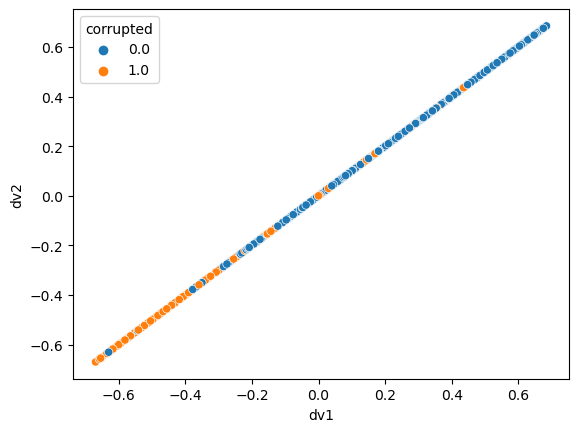

In [218]:
plt.figure()
sbn.scatterplot(x='dv1', y='dv2', hue='corrupted', data=res)
plt.show()

In [219]:
not_noise_idx = np.delete(np.arange(1000), noise_idx)

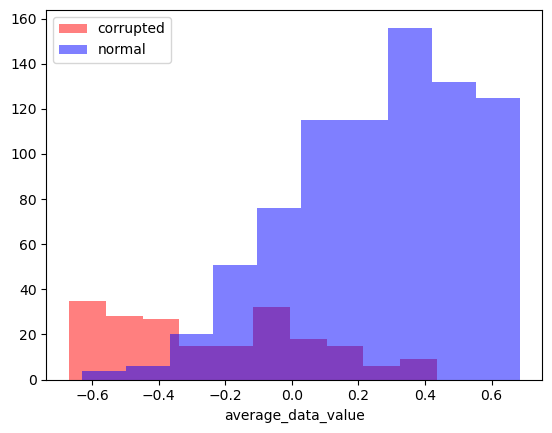

In [220]:
plt.figure()
plt.hist(sim_vals.mean(axis=1)[noise_idx], color='r', label='corrupted', alpha=0.5)
plt.hist(sim_vals.mean(axis=1)[not_noise_idx], color='b', label='normal', alpha=0.5)
plt.xlabel('average_data_value')
plt.legend()
plt.show()

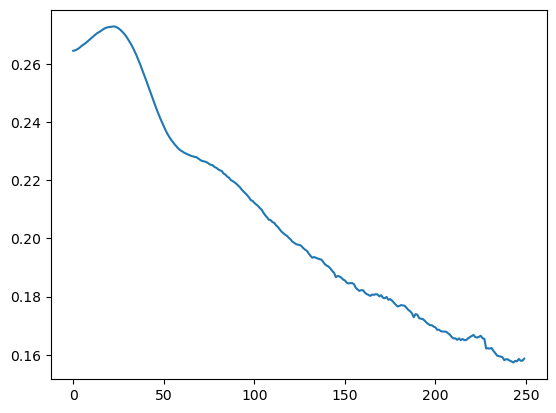

In [232]:
plt.figure()
plt.plot(sim_vals.mean(axis=0))
plt.show()

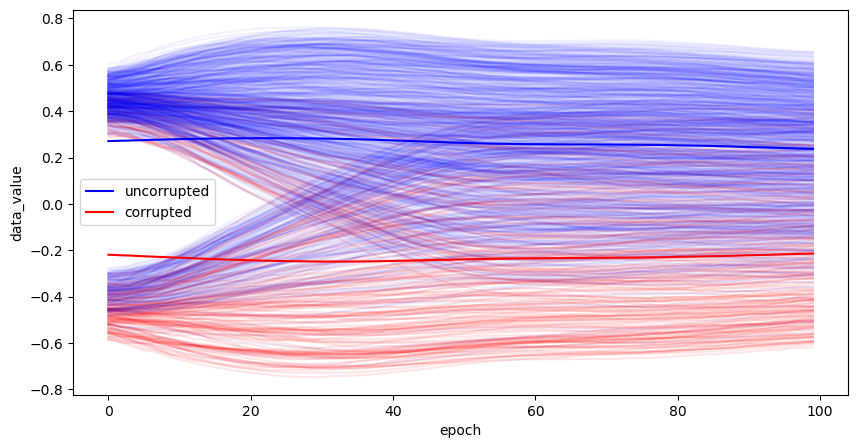

In [222]:
plt.figure(figsize=(10,5))
plt.plot(sim_vals[noise_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals[not_noise_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals[not_noise_idx, :].T.mean(axis=1), color='b', alpha=1., label='uncorrupted')
plt.plot(sim_vals[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.legend()
plt.show()

In [223]:

ks = np.linspace(1,500,500)
n_corrupt = []
n_perfect = [] 
n_random = [] 

dvs = sim_vals.mean(axis=1)
for k in ks: 
    idx = np.argpartition(dvs, int(k))[:int(k)]
    n_corrupt.append( len(set(noise_idx).intersection(set(idx)))/200 ) 
    n_perfect.append(min(int(k), 200)/200)
    n_random.append(len(set(noise_idx).intersection(set(np.random.randint(0,1000, size=int(k)))))/200)


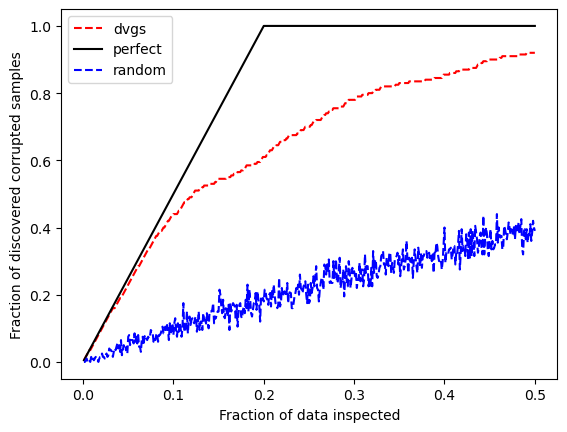

In [224]:
plt.figure()
plt.plot(ks/1000, n_corrupt, 'r--', label='dvgs')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

In [225]:
def train_model(x_train, y_train, x_test, y_test, epochs=200): 

    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0.1, bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid)

    crit = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters())

    for epoch in range(epochs): 

        optim.zero_grad()
        yhat_train = model(x_train).squeeze()
        loss = crit(yhat_train, y_train)
        loss.backward()
        optim.step()

    yhat_test = 1. * (model(x_test).detach().numpy() > 0.5).ravel()
    y_test = y_test.detach().numpy().ravel()

    acc = (yhat_test == y_test).sum() / y_test.shape[0]

    return acc

In [233]:
ks = np.linspace(0,500,20)
dvs = sim_vals.mean(axis=1)
high_accs = []
low_accs = []

for k in ks: 
    print(int(k), end='\r')
    sorted_idx = np.argsort(dvs)

    high_idxs = sorted_idx[0:(1000-int(k))]
    low_idxs = sorted_idx[(int(k)):]


    high_accs.append(train_model(x_train[high_idxs, :], y_train[high_idxs], x_test, y_test, epochs=500))
    low_accs.append(train_model(x_train[low_idxs, :], y_train[low_idxs], x_test, y_test, epochs=500))


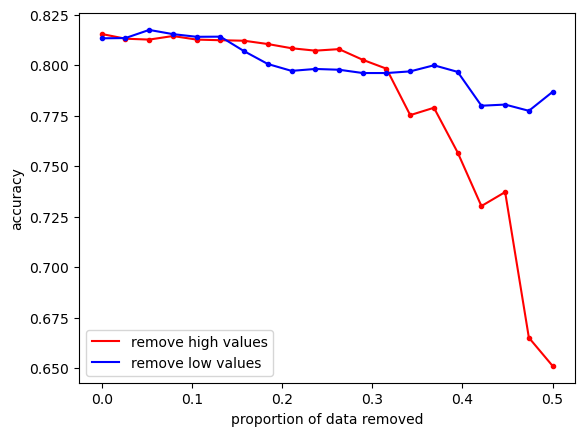

In [234]:
plt.figure()
plt.plot(ks/1000, high_accs, 'r-', label='remove high values')
plt.plot(ks/1000, high_accs, 'r.',)
plt.plot(ks/1000, low_accs, 'b-', label='remove low values')
plt.plot(ks/1000, low_accs, 'b.')
plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()

In [26]:
grad_valid

tensor([-1.3907e-04, -8.3000e-07, -1.5418e-04,  ...,  1.8947e-02,
         3.3013e-02,  1.9061e-01])

In [11]:
((model(x_train) - 0)**2).mean().backward()


In [15]:
torch.cat([p.grad.view(-1) for p in model.parameters()])

torch.Size([11001])

In [35]:
for p in model.parameters(): 
    print(p.data._grad)

None
None
None
None
